In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import gaitFunctions
from gaitFunctions import swingTimingProportions, adjust_lightness, colorBoxplot, colorViolinPlot
from matplotlib.collections import PathCollection
import combineClips
import plotClip
import os
import glob
import seaborn as sns
from scipy import stats
import cv2
from PIL import Image

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# Figure 2: Sample clip step kinematics and interleg coordination

In [3]:
excel_filename = '02_sampleclip.xlsx'
movie_file = '02_sampleclip.mov'
step_df = pd.read_excel(excel_filename, sheet_name='step_timing', index_col=None)
step_df.head(3)

,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,distance_during_step,distance_during_step_scaled,cruising_during_step,average_tardigrade_area,average_tardigrade_length,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change
0,L1,3.090,4.181,1.091,0.243,1.334,0.8178,4.3025,L1:0.9089,R1:0.057;0.6589,...,50.084031,0.052280,True,11394.875000,213.564508,NaN,0.819,NaN,NaN,NaN
1,L1,4.424,5.393,0.969,0.213,1.182,0.8198,5.4995,L1:0.9099,R1:0.6155,...,44.569661,0.046524,True,11274.625000,212.690571,NaN,0.485,NaN,NaN,NaN
2,L1,5.606,6.333,0.727,0.242,0.969,0.7503,6.4540,L1:0.8751,R1:0.4061,...,37.085644,0.038712,True,11414.833333,216.344908,NaN,0.545,NaN,NaN,NaN


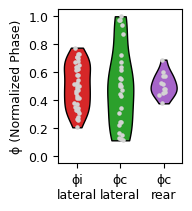

In [4]:
# get ipsilateral offsets normalized to gait cycle
ipsi_reflegs = ['L3','R3','L2','R2']
ipsi_complegs = ['L2','R2','L1','R1']
ipsi_offsets = []
ipsi_proportions = []
ipsi_speeds = []

for i, ref_leg in enumerate(ipsi_reflegs):
    comp_leg = ipsi_complegs[i]
    ipsi_offsets, ipsi_proportions, ipsi_speeds = swingTimingProportions(ipsi_offsets, 
                                                          ipsi_proportions, 
                                                          ipsi_speeds,
                                                          step_df, ref_leg, comp_leg)

# get contralateral offsets normalized to gait cycle FOR LEFT LATERAL LEGS
contra_reflegs = ['L3','L2','L1']
contra_complegs = ['R3','R2','R1']
contra_offsets = []
contra_proportions = []
contra_speeds = []

for i, ref_leg in enumerate(contra_reflegs):
    comp_leg = contra_complegs[i]
    contra_offsets, contra_proportions, contra_speeds = swingTimingProportions(
                                                          contra_offsets, 
                                                          contra_proportions, 
                                                          contra_speeds,
                                                          step_df, ref_leg, comp_leg)

# get contralateral offsets normalized to gait cycle FOR LEFT REAR LEGS
rear_reflegs = ['L4']
rear_complegs = ['R4']
rear_offsets = []
rear_proportions = []
rear_speeds = []

for i, ref_leg in enumerate(rear_reflegs):
    comp_leg = rear_complegs[i]
    rear_offsets, rear_proportions, rear_speeds = swingTimingProportions(
                                                          rear_offsets, 
                                                          rear_proportions, 
                                                          rear_speeds,
                                                          step_df, ref_leg, comp_leg)    

f,ax = plt.subplots(figsize=(1.6,2))
labels = ['ϕi\nlateral', 'ϕc\nlateral','ϕc\nrear']
ax = colorViolinPlot(ax,[ipsi_proportions, contra_proportions, rear_proportions],
                  [ipsi_color, contra_color, rear_leg_color],labels,pointcolor='lightgray',vwidth=0.6,
                     pointsize=5, inner=None)
ax.set_ylabel('ϕ (Normalized Phase)', fontsize=tick_fontsize)
ax.set_ylim([-0.05,1.05])
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

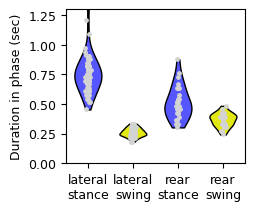

In [5]:
# violin plots for stance and swing
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
lateral_stances = step_df[step_df.legID.isin(lateral_legs)]['stance'].values
lateral_swings = step_df[step_df.legID.isin(lateral_legs)]['swing'].values
rear_stances = step_df[step_df.legID.isin(rear_legs)]['stance'].values
rear_swings = step_df[step_df.legID.isin(rear_legs)]['swing'].values
labels = ['lateral\nstance','lateral\nswing','rear\nstance','rear\nswing']

f,ax = plt.subplots(figsize=(2.3,2))
ax = colorViolinPlot(ax, [lateral_stances, lateral_swings,rear_stances, rear_swings], 
                      [stance_color, swing_color, stance_color, swing_color], labels,
                      pointcolor='lightgray',vwidth=0.6,pointsize=6,inner=None)
ax.set_ylabel('Duration in phase (sec)', fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_ylim([0,1.3])
plt.show()

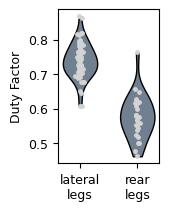

In [6]:
# violin plots for duty factor
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
labels = ['lateral\nlegs','rear\nlegs']
lateral_duty = step_df[step_df.legID.isin(lateral_legs)]['duty'].values
rear_duty = step_df[step_df.legID.isin(rear_legs)]['duty'].values

f,ax = plt.subplots(figsize=(1.3,2))
ax = colorViolinPlot(ax, [lateral_duty, rear_duty], 
                      ['slategray','slategray'], labels,
                      pointcolor='lightgray',vwidth=0.6,pointsize=6,inner=None)
ax.set_ylabel('Duty Factor', fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

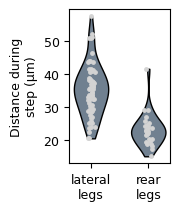

In [7]:
# violin plots for distance traveled
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
col = 'distance_during_step_scaled'
labels = ['lateral\nlegs','rear\nlegs']
lateral_distance= step_df[step_df.legID.isin(lateral_legs)][col].values * 1000
rear_distance = step_df[step_df.legID.isin(rear_legs)][col].values * 1000

f,ax = plt.subplots(figsize=(1.3,2))
ax = colorViolinPlot(ax, [lateral_distance, rear_distance], ['slategray','slategray'], labels,
                      pointcolor='lightgray', vwidth=0.6, pointsize=6, inner=None)
ax.set_ylabel('Distance during\nstep (µm)',fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

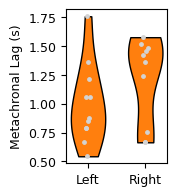

In [8]:
# violin plots for metachronal Lag Left vs. Right
right_ML = gaitFunctions.omitNan(step_df[step_df.legID=='R3']['metachronal_lag'].values)
left_ML = gaitFunctions.omitNan(step_df[step_df.legID=='L3']['metachronal_lag'].values)
ml_labels = ['Left','Right']
f,ax = plt.subplots(figsize=(1.3,2))
ax = colorViolinPlot(ax, [left_ML, right_ML], [mcl_color,mcl_color], ml_labels,
                      pointcolor='lightgray', vwidth=0.6, pointsize=6, inner=None)
ax.set_ylabel('Metachronal Lag (s)',fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

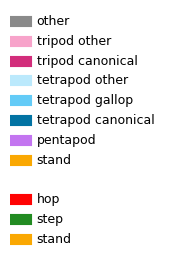

In [9]:
# legends for interleg coordination patterns
def comboLegend(ax):
    
    hex_all_combos, hex_colors = gaitFunctions.get_gait_combo_colors('lateral')
    rear_all_combos, rear_colors = gaitFunctions.get_gait_combo_colors('rear')
    no_need = ['unclassified','other','no data']
    hex_legend_combos = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
                        'tripod canonical','tripod other','other']
    rear_legend_combos =['stand','step','hop']

    i=0
    for combo in rear_legend_combos:
        combocolor = rear_colors[combo.replace(' ','_')]
        ax.plot([0,0.03],[i,i],color=combocolor,linewidth=8)
        ax.text(0.05,i-0.2,s=combo,c='k',fontsize=tick_fontsize)
        i +=1

    i += 1 # or more?

    for combo in hex_legend_combos:
        combocolor = hex_colors[combo.replace(' ','_')]
        ax.plot([0,0.03],[i,i],color=combocolor,linewidth=8)
        ax.text(0.05,i-0.2,s=combo,c='k',fontsize=tick_fontsize)
        i +=1
    
    ax.set_axis_off()
    ax.set_xlim([0,0.3])
    return ax

f = plt.figure(figsize=(2,3))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = comboLegend(ax)

plt.show()

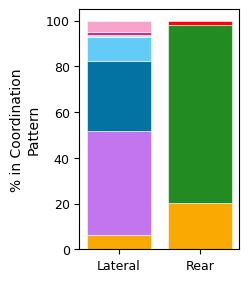

In [10]:
# ICPs for rear and lateral on one axis
def comboProportionsPlot(ax):

    hex_all_combos, hex_colors = gaitFunctions.get_gait_combo_colors('lateral')
    rear_all_combos, rear_colors = gaitFunctions.get_gait_combo_colors('rear')
    no_need = ['unclassified','other','no data']
    hex_legend_combos = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
                        'tripod canonical','tripod other','other']
    rear_legend_combos =['stand','step','hop']
    
    hextimes,hex_gait_styles = gaitFunctions.getGaitStyleVec(excel_filename,'lateral')
    hex_combo_proportions = gaitFunctions.percentagesFromList(hex_gait_styles)
    
    reartimes,rear_gait_styles = gaitFunctions.getGaitStyleVec(excel_filename,'rear')
    rear_combo_proportions = gaitFunctions.percentagesFromList(rear_gait_styles)
    
    barwidth = 0.8
    
    bottom = 0
    xpos = 1
    for i, combo in enumerate(hex_legend_combos):
        combo_key = combo.replace(' ','_')
        if combo_key in hex_combo_proportions.keys():
            combo_proportion = hex_combo_proportions[combo_key]
            ax.bar(xpos, combo_proportion, bottom=bottom, color=hex_colors[combo_key],
                  edgecolor='white', linewidth=0.4, width = barwidth)
            bottom += combo_proportion
    
    xpos = 2
    bottom = 0
    for i, combo in enumerate(rear_legend_combos):
        combo_key = combo.replace(' ','_')
        if combo_key in rear_combo_proportions.keys():
            combo_proportion = rear_combo_proportions[combo_key]
            ax.bar(xpos, combo_proportion, bottom=bottom, color=rear_colors[combo_key],
                  edgecolor='white', linewidth=0.4, width = barwidth)
            bottom += combo_proportion
            
    ax.set_ylabel('% in Coordination\nPattern')
    ax.set_xticks([1,2],['Lateral','Rear'])
              
    return ax
    
f = plt.figure(figsize=(2,3))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = comboProportionsPlot(ax)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.show()

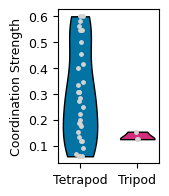

In [11]:
# coordination strength
gait_styles_df = pd.read_excel(excel_filename, sheet_name='gait_styles')
tetrapod_coordination = gaitFunctions.omitNan(gait_styles_df['tetrapod_coordination'].values)
tripod_coordination = gaitFunctions.omitNan(gait_styles_df['tripod_coordination'].values)
# print(tetrapod_coordination)
# print(tripod_coordination)
hex_all_combos, hex_colors = gaitFunctions.get_gait_combo_colors('lateral')
tet_color = hex_colors['tetrapod_canonical']
tri_color = hex_colors['tripod_canonical']

f,ax = plt.subplots(figsize=(1.3,2))
tcs_labels = ['Tetrapod','Tripod']
ax = colorViolinPlot(ax, [tetrapod_coordination, tripod_coordination], [tet_color, tri_color], tcs_labels,
                      pointcolor='lightgray', vwidth=0.6, pointsize=6, inner=None)
ax.set_ylabel('Coordination Strength',fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

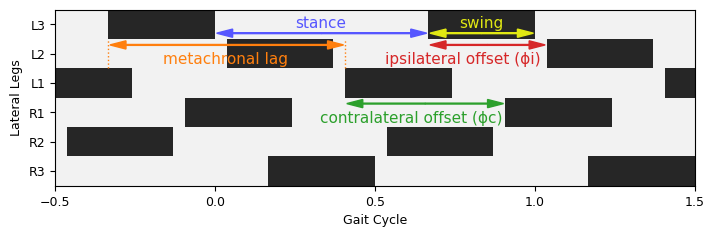

In [12]:
# annotated step diagram
def annotatedStepDiagram(ax, add_mcl=True):
    
    num_legs = 6
    num_cycles = 3 
    duty_factor = 2/3 
    anterior_offset = 0.37
    opposite_offset = 1/2
    ax, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax, num_legs, num_cycles, duty_factor, anterior_offset, opposite_offset)

    # arrow parameters
    arrow_width = 0.03
    headwidth = 0.28
    headlength = 0.05
    arrow_buffer = 0.005

    # text label offsets
    stance_buffer = 0.082
    swing_buffer = 0.07
    ipsi_buffer = 0.32
    contra_buffer = 0.33
    mcl_buffer = 0.2

    # arrows and text for STANCE
    arrow_x = duty_factor / 2
    arrow_y = 6.2
    dx = duty_factor / 2 - arrow_buffer
    stance_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=stance_color)
    ax.add_patch(stance_arrow_right)
    stance_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=stance_color)
    ax.add_patch(stance_arrow_left)

    ax.text(arrow_x - stance_buffer, 6.4, 'stance', fontsize=axis_fontsize, color = stance_color)

    # arrows and text for SWING
    arrow_x = duty_factor + (1 - duty_factor)/2
    arrow_y = 6.2
    dx = ((1 - duty_factor) / 2) - arrow_buffer
    swing_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=swing_color)
    ax.add_patch(swing_arrow_right)
    swing_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=swing_color)
    ax.add_patch(swing_arrow_left)

    ax.text(arrow_x - swing_buffer, 6.4, 'swing', fontsize=axis_fontsize, color = swing_color)

    # arrows and text for IPSILATERAL OFFSET
    arrow_x = duty_factor + anterior_offset/2
    arrow_y = 5.8
    dx = (anterior_offset/2) - arrow_buffer
    anterior_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=ipsi_color)
    ax.add_patch(anterior_arrow_right)
    anterior_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=ipsi_color)
    ax.add_patch(anterior_arrow_left)

    ax.text(arrow_x - ipsi_buffer, 5.15, 'ipsilateral offset (ϕi)', fontsize=axis_fontsize, color=ipsi_color)

    # arrows and text for CONTRALATERAL OFFSET
    arrow_x = 2 * anterior_offset - (1-duty_factor) + opposite_offset/2
    arrow_y = 3.8
    dx = (opposite_offset/2) - arrow_buffer
    opposite_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=contra_color)
    ax.add_patch(opposite_arrow_right)
    opposite_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=contra_color)
    ax.add_patch(opposite_arrow_left)

    ax.text(arrow_x - contra_buffer, 3.15, 'contralateral offset (ϕc)', fontsize=axis_fontsize, color=contra_color)
    
    if add_mcl:
        # arrows and text for METACHRONAL LAG
        mcl = 2 * anterior_offset
        mcl_start = - (1-duty_factor)
        mcl_end = - (1-duty_factor) + mcl
        arrow_x = mcl_start + mcl / 2
        arrow_y = 5.8
        dx = (mcl/2) - arrow_buffer
        mcl_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                    width=arrow_width, length_includes_head=True, color=mcl_color)
        ax.add_patch(mcl_arrow_right)
        mcl_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                    width=arrow_width, length_includes_head=True, color=mcl_color)
        ax.add_patch(mcl_arrow_left)
        # dashed lines for boundaries
        ax.plot([mcl_start,mcl_start],[5,6],':',color=mcl_color,linewidth=1)
        ax.plot([mcl_end,mcl_end],[5,6],':',color=mcl_color,linewidth=1)
        ax.text(arrow_x - mcl_buffer, 5.15, 'metachronal lag', fontsize=axis_fontsize, color=mcl_color)
    
    # axis limits and labels
    xlow = -0.5
    xhigh = 1.5
    ax.set_xlim([xlow, xhigh])
    ax.set_xticks(np.arange(xlow, xhigh+0.5, 0.5))
    
    return ax

f = plt.figure(figsize=(8,2.2))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax=annotatedStepDiagram(ax)
ax.set_ylabel('Lateral Legs', fontsize=tick_fontsize)
ax.xaxis.label.set_size(tick_fontsize)
ax.xaxis.set_tick_params(labelsize=tick_fontsize)
ax.yaxis.set_tick_params(labelsize=tick_fontsize)
plt.show()

11 11
Spearman  -0.42 , p = 0.2


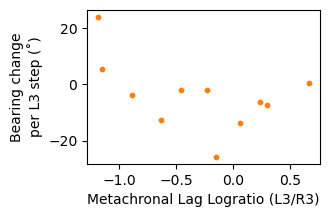

In [13]:
# metachronal lag vs. bearing change
mcl_ratios = gaitFunctions.omitNan(step_df['mcl_LR_ratio'].values)
l3_bearing_changes = gaitFunctions.omitNan(step_df['L3_bearing_change'].values)
print(len(mcl_ratios), len(l3_bearing_changes))
r,p = stats.spearmanr(mcl_ratios,l3_bearing_changes)
print('Spearman ', np.round(r,2), ', p =',np.round(p,2))
f,a = plt.subplots(1,1,figsize=(3,2))
if p < 0.05:
    sns.regplot(ax=a, x=mcl_ratios, y=l3_bearing_changes, scatter_kws={'s':marker_size,'color':mcl_color}, 
                    line_kws={'color':mcl_color,'linewidth':2})
else:
    a.scatter(mcl_ratios,l3_bearing_changes,s=marker_size,c=mcl_color)
a.set_xlabel('Metachronal Lag Logratio (L3/R3)')
a.set_ylabel('Bearing change\nper L3 step (˚)')

plt.show()

# Figure 02: all

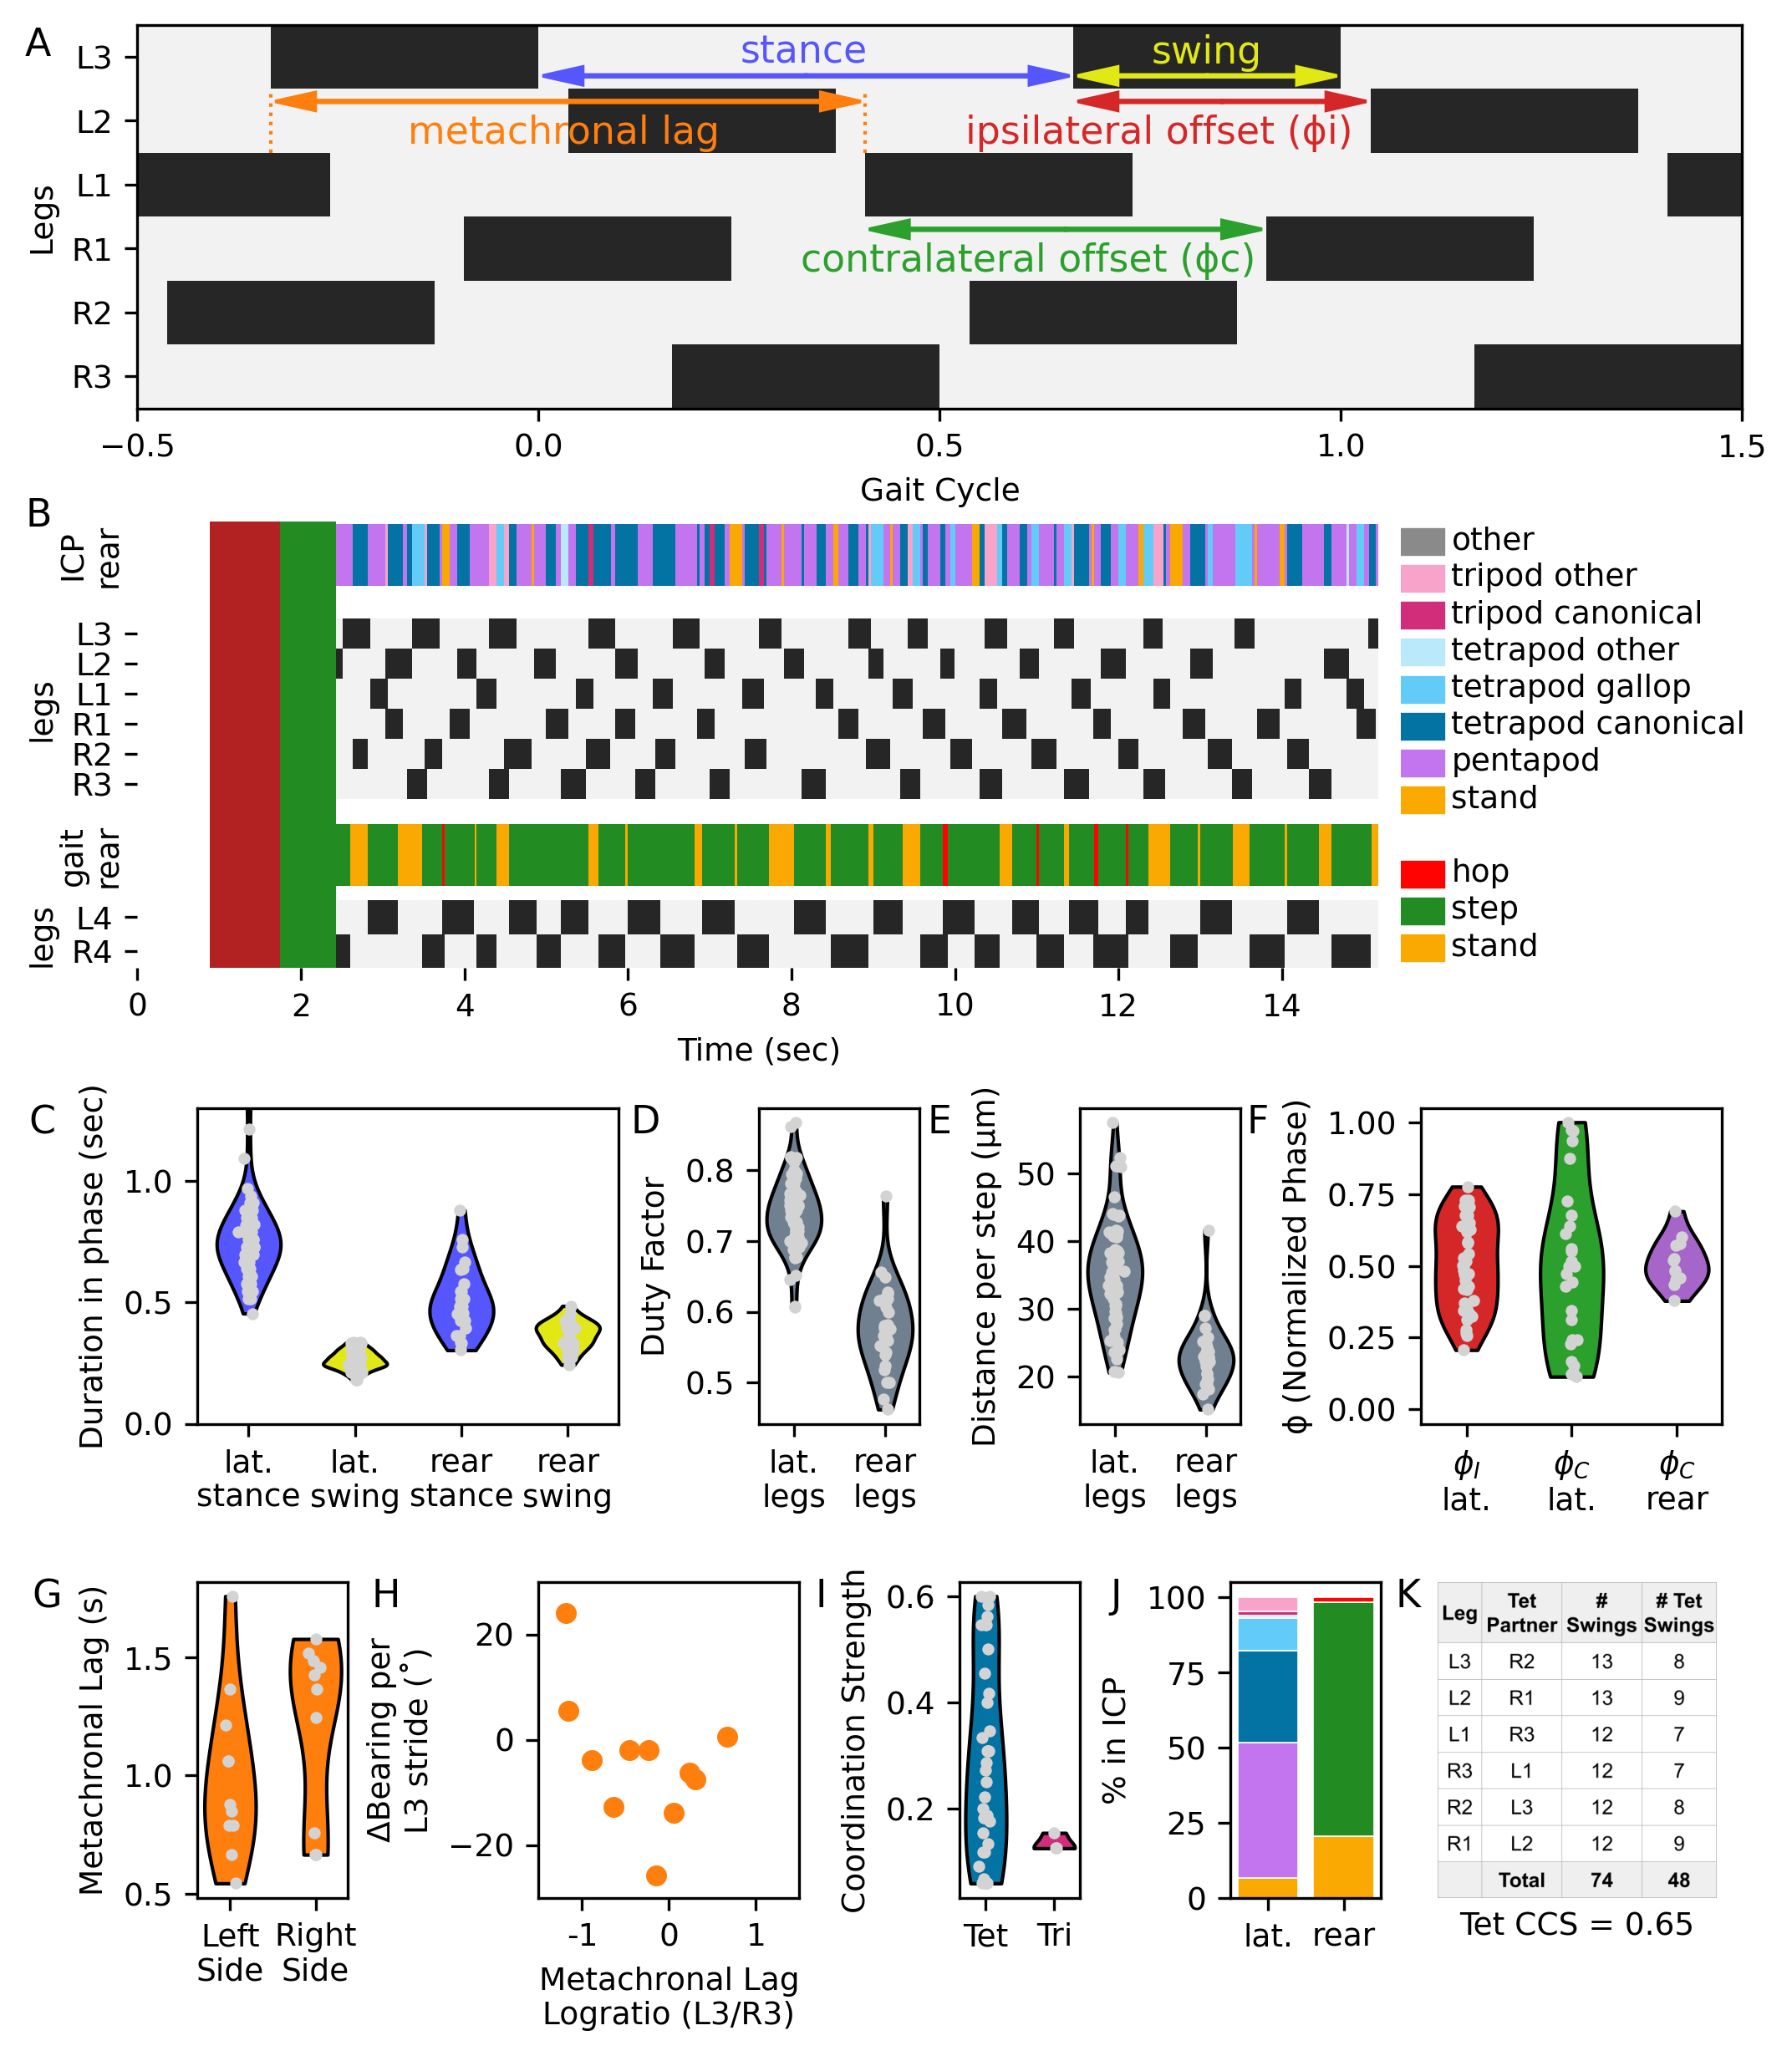

In [123]:
f = plt.figure(1, figsize=(8,9), dpi=300)

tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)
path_stats = gaitFunctions.loadPathStats(movie_file)
scale = float(path_stats['scale'])
unit = path_stats['unit']
last_frame = tracked_df.times.values[-1]
xlim = ([0,last_frame])

#### set up axes locations
diagram_ax = f.add_axes([0.05,0.78,0.8,0.17])
lateralgaits_ax = f.add_axes([0.05, 0.7, 0.62, 0.03]) 
lateralsteps_ax = f.add_axes([0.05, 0.607, 0.62, 0.08])
reargaits_ax = f.add_axes([0.05, 0.567, 0.62, 0.03])
rearsteps_ax = f.add_axes([0.05, 0.532, 0.62, 0.03])

red_ax = f.add_axes([0.086,0.532,0.035,0.198])
red_ax.set_facecolor('firebrick')
green_ax = f.add_axes([0.121,0.532,0.028,0.198])
green_ax.set_facecolor('forestgreen')

for ax in [red_ax,green_ax]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

combo_legend_ax = f.add_axes([0.68, 0.532, 0.15, 0.198])

ss_ax =           f.add_axes([0.08, 0.33, 0.21, 0.14]) # stance & swing (all four)
duty_ax =         f.add_axes([0.36, 0.33, 0.08, 0.14]) # duty (lat, rear)
distancestep_ax = f.add_axes([0.52, 0.33, 0.08, 0.14]) # distance / step axis (lateral, rear)
offsets_ax =      f.add_axes([0.69, 0.33, 0.15, 0.14]) # offsets (lat lat rear)

mcl_lr_ax =                f.add_axes([0.080, 0.12, 0.075, 0.14])
mcl_bearing_ax =           f.add_axes([0.250, 0.12, 0.130, 0.14]) # metachronal lag vs bearings scatter
coordination_strength_ax = f.add_axes([0.460, 0.12, 0.060, 0.14])
coordination_patterns_ax = f.add_axes([0.595, 0.12, 0.075, 0.14])
ccs_ax =                   f.add_axes([0.695, 0.12, 0.145, 0.14])

### make the plot
# annotated step diagram
diagram_ax = annotatedStepDiagram(diagram_ax)

# plot the gait styles for lateral legs
lateralgaits_ax = gaitFunctions.plotGaits(lateralgaits_ax, excel_filename, 'lateral')
lateralgaits_ax.set_xlim(xlim)
lateralgaits_ax.set_ylabel('ICP\nlat.')

# plot the steps for the lateral legs
lateral_legs = gaitFunctions.get_leg_combos()[0]['legs_lateral']
lateralsteps_ax = gaitFunctions.plotLegSet(lateralsteps_ax, movie_file, lateral_legs)
lateralsteps_ax.set_xlabel('')
lateralsteps_ax.set_xticks([])
lateralsteps_ax.set_xlim(xlim)

# plot the gait styles for rear legs
reargaits_ax = gaitFunctions.plotGaits(reargaits_ax, excel_filename, 'rear')
reargaits_ax.set_xlim(xlim)
lateralgaits_ax.set_ylabel('ICP\nrear')

# plot the steps for the rear legs
rear_legs = gaitFunctions.get_leg_combos()[0]['legs_4']
rearsteps_ax = gaitFunctions.plotLegSet(rearsteps_ax, movie_file, rear_legs)
rearsteps_ax.set_xlim(xlim)
# rear_steps.set_xticks([])

# legend for coordination patterns (aka gait styles)
combo_legend_ax = comboLegend(combo_legend_ax)

# stance and swing
ss_labels =['lat.\nstance','lat.\nswing','rear\nstance','rear\nswing']
ss_ax = colorViolinPlot(ss_ax, [lateral_stances, lateral_swings,rear_stances, rear_swings], 
                      [stance_color, swing_color, stance_color, swing_color], ss_labels,
                       pointcolor='lightgray',vwidth=0.6,pointsize=6,inner=None)
ss_ax.set_ylabel('Duration in phase (sec)')
ss_ax.set_ylim([0,1.3])

# duty factor
duty_labels = ['lat.\nlegs','rear\nlegs']
duty_ax = colorViolinPlot(duty_ax, [lateral_duty, rear_duty], 
                      ['slategray','slategray'], duty_labels,
                          pointcolor='lightgray',vwidth=0.6,pointsize=6,inner=None)
duty_ax.set_ylabel('Duty Factor')

# distance per step for lateral legs and rear legs
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
col = 'distance_during_step_scaled'
dist_labels = ['lat.\nlegs','rear\nlegs']
lateral_distance= step_df[step_df.legID.isin(lateral_legs)][col].values * 1000
rear_distance = step_df[step_df.legID.isin(rear_legs)][col].values * 1000
distancestep_ax = colorViolinPlot(distancestep_ax, [lateral_distance, rear_distance], 
                      ['slategray','slategray'], dist_labels, 
                                  pointcolor='lightgray',vwidth=0.6,pointsize=6,inner=None)
distancestep_ax.set_ylabel('Distance per step (µm)')

# offsets
offset_labels = ['$ϕ_{I}$\nlat.', '$ϕ_{C}$\nlat.','$ϕ_{C}$\nrear']
offsets_ax = colorViolinPlot(offsets_ax,[ipsi_proportions, contra_proportions, rear_proportions],
                  [ipsi_color, contra_color, rear_leg_color],offset_labels,
                             pointcolor='lightgray',vwidth=0.6,pointsize=6,inner=None)
offsets_ax.set_ylim([-0.05,1.05])
offsets_ax.set_ylabel('ϕ (Normalized Phase)')

# metachronal leg Left vs. Right
mcl_lr_ax = colorViolinPlot(mcl_lr_ax, [left_ML, right_ML], [mcl_color,mcl_color], ['Left\nSide','Right\nSide'],
                      pointcolor='lightgray', vwidth=0.6, pointsize=6, inner=None)
mcl_lr_ax.set_ylabel('Metachronal Lag (s)')

# metachronal lag vs. direction change (bearing change)
mcl_marker_size = 25
mcl_bearing_ax.scatter(mcl_ratios,l3_bearing_changes,s=mcl_marker_size,c=mcl_color)
# sns.regplot(ax=mcl_ax, x=mcl_ratios, y=l3_bearing_changes, scatter_kws={'s':marker_size,'color':mcl_color}, 
#                     line_kws={'color':mcl_color,'linewidth':2})
mcl_bearing_ax.set_xlabel('Metachronal Lag\nLogratio (L3/R3)', fontsize=tick_fontsize)
mcl_bearing_ax.set_ylabel('ΔBearing per\nL3 stride (˚)', fontsize=tick_fontsize)
mcl_bearing_ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
mcl_bearing_ax.set_ylim([-30,30])
mcl_bearing_ax.set_xlim([-1.5,1.5])
mcl_bearing_ax.set_xticks([-1,0,1],[str(x) for x in [-1,0,1]])

# coordination strength
tcs_labels = ['Tet','Tri']
coordination_strength_ax = colorViolinPlot(coordination_strength_ax, [tetrapod_coordination, tripod_coordination], 
                                           [tet_color, tri_color], tcs_labels, pointcolor='lightgray', 
                                           vwidth=0.6, pointsize=6, inner=None)
coordination_strength_ax.set_ylabel('Coordination Strength')

# coordination pattern proportions
coordination_patterns_ax = comboProportionsPlot(coordination_patterns_ax)
coordination_patterns_ax.set_ylabel('% in ICP')
coordination_patterns_ax.set_xticks([1,2],['lat.','rear'])

# coordination consistency score
ccs_table = np.asarray(Image.open('02 coordination consistency table.png'))
ccs_ax.imshow(ccs_table)
ccs_ax.set_xticks([])
ccs_ax.set_yticks([])
for edge in ['top','right','bottom','left']:
    ccs_ax.spines[edge].set_visible(False)
ccs_ax.set_xlabel('Tet CCS = 0.65', fontsize=tick_fontsize)
    
# adjust parameters and show plot
for ax in [diagram_ax, lateralsteps_ax, rearsteps_ax, lateralgaits_ax, reargaits_ax]:
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
for ax in [ss_ax, duty_ax, distancestep_ax, offsets_ax]:
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
for ax in [mcl_lr_ax, mcl_bearing_ax, coordination_strength_ax, coordination_patterns_ax]:
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
rearsteps_ax.xaxis.label.set_size(tick_fontsize)
rearsteps_ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# add figure letter labels
diagram_ax.annotate('A', xy=(-0.07, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
lateralgaits_ax.annotate('B', xy=(-0.09, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

ss_ax.annotate('C', xy=(-0.4, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
duty_ax.annotate('D', xy=(-0.8, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
distancestep_ax.annotate('E', xy=(-0.95, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
offsets_ax.annotate('F', xy=(-0.58, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

mcl_lr_ax.annotate('G', xy=(-1.1, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
mcl_bearing_ax.annotate('H', xy=(-0.64, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
coordination_strength_ax.annotate('I', xy=(-1.2, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
coordination_patterns_ax.annotate('J', xy=(-0.8, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
ccs_ax.annotate('K', xy=(-0.15, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

# show plot
plt.show()

In [66]:
# coordinationComboConsistency: copied and modified from gaitFunctions 3 Aug 1:50pm

def clipCoordinationComboConsistency(gait_styles_df, icp):  # 'tetrapod' or 'tripod'
    
    '''
    calculates coordination consistency score (CCS) 
    
    for each leg, finds the most common tetrapod or tripod ICP for that leg within a clip
    then calculates proportion of all strides of that leg that contain that particular ICP
    assigns a score to each tardigrade by calculating # strides with ICP / total strides
    (summed across all legs)
    
    inputs = 
        gait_styles_df (from an individual clip)
        icp = 'tetrapod or 'tripod'
        
    returns = 
        
    '''
    print('leg common_swingpartner total_swings swings_with_partner')
    
    coord_consistency_dict = {}
    legs = ['L3','L2','L1','R3','R2','R1']
    
    icp_combos = gaitFunctions.canonicalComboList(icp)
    # print(icp_combos) # testing OK
    
    swinging_legs = gait_styles_df['swinging_lateral'].values
    # print(swinging_legs)  # testing OK
    
    combo_counts = {}            
    for combo in icp_combos:
        combo_counts[combo] = len(np.where(swinging_legs == combo)[0])
    # print(combo_counts) # testing OK

    # keep track of all data
    total_swings = 0
    total_swings_with_icp = 0
    
    # for each leg, get # of swings
    # and figure out how many steps for this leg have the most prevalent combo
    for leg in legs:
        
        swings_with_icp = 0
        
        # get the icp combos for this leg
        leg_combos = gaitFunctions.combosWithLeg(leg, icp)
        
        # figure out which combo is most prevalent for this leg
        counter = 0
        for leg_combo in leg_combos:
            if combo_counts[leg_combo] > counter:
                common_icp = leg_combo
                counter = combo_counts[leg_combo]
        # print(leg, common_icp) # testing OK

        # make vector of 1's (swings for this leg) and 0's
        swings_for_this_leg = np.zeros(len(swinging_legs))
        for i, swing in enumerate(swinging_legs):
            try:
                if leg in swing:
                    swings_for_this_leg[i] = 1
            except:
                swings_for_this_leg[i] = 0
        # print(leg, swings_for_this_leg) # testing OK

        # From this vector, get num_swings (aka number of 1 runs)
        swings = gaitFunctions.one_runs(swings_for_this_leg)
        swings_for_leg = len(swings)

        # For each swing
        for swing in swings:
            # get each swing start through swing end
            swing_start = swing[0]
            swing_end = swing[1]

            # Check vector of swinging_legs within this interval ... is common_icp in there?
            if common_icp in swinging_legs[swing_start:swing_end]:
#                 print(leg,'yes',common_icp, swinging_legs[swing_start:swing_end]) # testing OK
                swings_with_icp += 1
#             else:
#                 print(leg,'no',common_icp, swinging_legs[swing_start:swing_end]) # testing OK

        # Finished collecting data for this leg 
        # report results
        swingpartner = common_icp.replace('_','')
        swingpartner = swingpartner.replace(leg,'')
        
        print(leg, swingpartner, swings_for_leg, swings_with_icp)
        total_swings += swings_for_leg
        total_swings_with_icp += swings_with_icp
        
    print('\nTotal Swings: ', total_swings, '\nSwings in ICP:', total_swings_with_icp, 
          '\nCCS:          ', np.round(total_swings_with_icp/total_swings,2))
    
    
    return 

In [67]:
print(excel_filename)
gait_styles_df = pd.read_excel(excel_filename, sheet_name='gait_styles', index_col=None)
clipCoordinationComboConsistency(gait_styles_df, 'tetrapod')

02_sampleclip.xlsx
leg common_swingpartner total_swings swings_with_partner
L3 R2 13 8
L2 R1 13 9
L1 R3 12 7
R3 L1 12 7
R2 L3 12 8
R1 L2 12 9

Total Swings:  74 
Swings in ICP: 48 
CCS:           0.65
